# SIFT

SIFT is a feature based image registration algorithm developed by David Lowe in 1999. It works by detecting feature points between two images and switching them based on common points between the two images. Its applications range from basic panorama creation to satellite imagery, and facial recognition in video.

There are five major steps:

- **scale-space construction**: convolving an image repeatedly using Gaussian filter with changing scales
- **scale space extrema detection**: Difference of Gaussian (DoG) images are computed from Gaussian-blurred images
- **keybpoint localization**: identified as local extrma of DoG across the scales.
- **orientation assignment**: low contrast keypoints and edge response points are discarded
- **defining keypoint descriptors**: assigned one or more orientations based on the local image gradient directions

Orientation histograms are formed over heighborhoods of keypoints. A normalized 128-dimensional vector is computed for each keypoint as its _descriptor_. Nearest neighbor of a keypoint in the first image is identified from a database of keypoints from the second image. RANSAC is used to remove outpiers and to compute the transformation parameters between a pari of frames. Finally, they are warped using transformation parameters to create the mosaic image.

## But we're not using SIFT here, we're using A-KAZE
[OpenCV python matcher](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html).

Accelerated KAZE relies on fast explicit diffusion (FED) to the feature detection and description components \cite{AKAZE}.

In [1]:
import cv2
import imageio

In [2]:
def get_akaze_keypoints(im):
    akaze = cv2.AKAZE_create()
    return akaze.detectAndCompute(im, None)

In [3]:
im1 = imageio.imread('../data/T1_segment_rot_1.tif')
im2 = imageio.imread('../data/T1_segment_rot_2.tif')

(kp_1, desc_1) = get_akaze_keypoints(im1)
(kp_2, desc_2) = get_akaze_keypoints(im2)

In [4]:
bf = cv2.BFMatcher()
# Match descriptors.
matches = bf.knnMatch(desc_1, desc_2, k=2)
matches = sorted(matches, key = lambda x:x[0].distance)
better_matches = [ m[0] for m in matches if m[0].distance < 0.75 * m[1].distance]

Plot the points.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side
    This could use PIL.Image.paste, but it complains about tuples.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

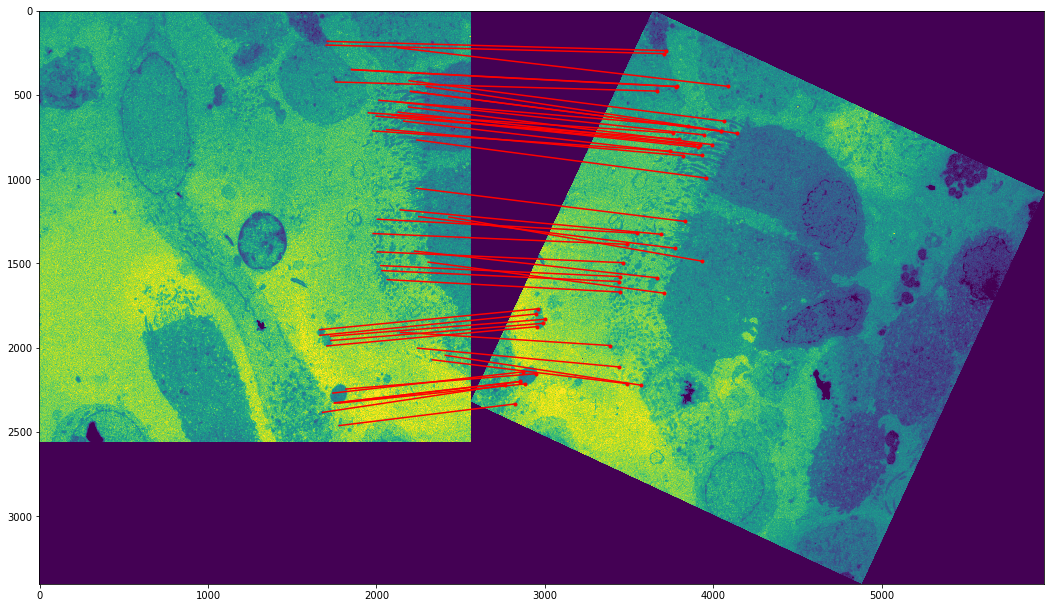

In [6]:
im3 = concat_images(im1, im2)

fig=plt.figure(figsize=(18, 16), dpi=72)
plt.imshow(im3)

ax = plt.gca()

for m in better_matches[:50]:
    kp_a = kp_1[m.queryIdx].pt
    kp_b = kp_2[m.trainIdx].pt
    l = mlines.Line2D([kp_a[0], kp_b[0]+im1.shape[0]], 
                      [kp_a[1], kp_b[1]], color='r', marker='.', markevery=(1,1))
    ax.add_line(l)
        
plt.show()

## Homography to warp the images back together

[Basic Homography](https://docs.opencv.org/3.4.1/d9/dab/tutorial_homography.html)  
[Feature Matching](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html)  
[Warping documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#void%20warpAffine(InputArray%20src,%20OutputArray%20dst,%20InputArray%20M,%20Size%20dsize,%20int%20flags,%20int%20borderMode,%20const%20Scalar&%20borderValue))

In [1]:
from math import floor
from PIL import Image

def paste(canvas, paint):
    '''
    Paste an image on to another using masks.
    '''
    h, w = canvas.shape
    p_h, p_w = paint.shape
    nw, nh = (0,0)
    if w < p_w:
        nw = p_w - w
    if h < p_h:
        nh = p_h - h
    output = np.copy(canvas)
    output = np.pad(output, ((0, nh), (0, nw)), 'constant', constant_values=(0,0))
    
    # mask magic!
    o_mask = np.ma.equal(output, 0)
    output[o_mask] = paint[o_mask] # for places where output is 0: paint.
    return output

SyntaxError: invalid syntax (<ipython-input-1-9aa647197f58>, line 8)

In [2]:
# Warp the second image to best match the first.
src_pts = np.float32([ kp_2[m.trainIdx].pt for m in better_matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_1[m.queryIdx].pt for m in better_matches ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
h,w = im1.shape
# use the homography offsets to determine the size for the stitched image
x_offset, y_offset = M[0:2, 2]
new_size = (int(max(w, w+x_offset)), int(max(h, h+y_offset)))

# warp!
dst = cv2.warpAffine(im2, M[:2,:3], new_size, flags=cv2.INTER_CUBIC)
# dst = cv2.warpPerspective(im2, M, (w*2, h*2), flags=cv2.INTER_CUBIC)

stitched = paste(im1, dst)
imageio.imwrite('../data/stitched.tif', stitched)

fig=plt.figure(figsize=(18, 16), dpi=72)
plt.imshow(stitched)
plt.show()

NameError: name 'np' is not defined

In [3]:
M[0:2,2]

NameError: name 'M' is not defined

In [10]:
M

array([[ 9.06679769e-01,  4.22870013e-01,  5.55192118e+02],
       [-4.22569057e-01,  9.06609928e-01,  4.57043535e+02],
       [ 8.87428787e-08,  7.68663743e-08,  1.00000000e+00]])

In [ ]:
def crop_zeros(im):
    '''
    Crop zeros around an image
    '''
    r,c = im.shape
    top = 0
    left = 0
    bottom = r-1
    right = c-1
    while sum(im[top,:]) == 0:
        top += 1
        
    while sum(im[bottom,:]) == 0:
        bottom -=1    
        
    while sum(im[:,left]) == 0:
        left +=1
        
    while sum(im[:,right]) == 0:
        right -=1
    
    return im[top:bottom+1,left:right+1]

cropped = crop_zeros(stitched)

fig=plt.figure(figsize=(18, 16), dpi=72)
plt.imshow(cropped)
plt.show()

In [36]:
# Check cropped size
ch, cr = cropped.shape
sh, sr = stitched.shape
print('%d,%d / %.01f%%,%.01f%%' % (ch-sh, cr-sr, ch/sh*100, cr/sr*100))

-13899,-13901 / 22.9%,22.8%


In [42]:
imageio.imwrite('../data/cropped.tif', cropped)
cropped.shape

(4117, 4115)

## Compare with Ground Truth

In [39]:
'''
Load original image
pixel-wise diff
different pixels count / total pixels in overlap?
-> precision.
'''
orig = imageio.imread('../data/T1_Img_002.00.tif')
orig.shape

(4096, 4096)

In [41]:
# Sum absolute differences.
np.sum(np.abs(orig - cropped[:4096,:4096]))

382076410549

In [48]:
# Total differenes
total_px = 4096 ** 2
diffs = np.count_nonzero(orig - cropped[:4096,:4096])

# percent the same
diffs / total_px

0.6927249431610107